## Аналитика пользовательского поведения на основе сырых логов

Выполнила: **Шитова Анастасия**, группа DA-11

### Цель работы
В данной работе хотелось изучить, какую информацию о пользователях, их активности, характеристиках пользователей и взаимодействиях между клиентом и сервером можно получить из логов сервера, поскольку информация логов доступна, и её сбор и систематизация сравнительно просты по затратам: логи, как правило, пишутся по умолчанию, возможно, может потребоваться только изменение формата их записи.

### Загрузка данных

Исследовательская работа выполнена на основе данных серверных логов иранского маркетплейса zanbil.ir за январь 2019 год (файл формата *.log). Для выполнения анализа и загрузки данных в датасет была выполнена предварительная конвертация данных в формат parquet, что существенно уменьшило размер обрабатываемых файлов (с 3.5 Гб до 264 Мб) и позволило обработать файл логов поэтапно, частями. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)    # Show all rows
pd.set_option('display.max_colwidth', None) # Allow wrapping for long values

In [13]:
import os
import re
from tqdm import tqdm

for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/client_hostname.csv
./kaggle/input/access.log


In [5]:
# Паттерн строки лога
regex = r'^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)'

# Названия столбцов
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

In [7]:
# Функция для преобразования файла логов в файлы формата parquet
def logs_to_df(logfile, output_dir, errors_file):
    """
    Parse log file and save parsed data into DataFrame, then save DataFrame to Parquet files.

    Args:
        logfile (str): Path to the log file.
        output_dir (str): Directory to save Parquet files.
        errors_file (str): Path to the file to store parsing errors.

    Returns:
        None
    """
    with open(logfile) as source_file:
        linenumber = 0
        parsed_lines = []
        for line in tqdm(source_file):
            try:
                log_line = re.findall(regex, line)[0]
                parsed_lines.append(log_line)
            except Exception as e:
                with open(errors_file, 'at') as errfile:
                    print((line, str(e)), file=errfile)
                continue
            linenumber += 1
            if linenumber % 250_000 == 0:
                df = pd.DataFrame(parsed_lines, columns=columns)
                df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
                parsed_lines.clear()
        else:
            df = pd.DataFrame(parsed_lines, columns=columns)
            df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
            parsed_lines.clear()

In [9]:
# Создание каталога для файлов parquet
!mkdir parquet_dir

In [15]:
# Запуск конвертации файла логов в файлы parquet
%time logs_to_df(logfile='./kaggle/input/access.log', output_dir='parquet_dir/', errors_file='errors.txt')

10365152it [00:22, 451103.73it/s]


CPU times: user 21.4 s, sys: 1.52 s, total: 22.9 s
Wall time: 23.5 s


In [141]:
# Загрузка файлов parquet в датафрейм
%time df = pd.read_parquet('parquet_dir/')

CPU times: user 3.36 s, sys: 2.51 s, total: 5.87 s
Wall time: 5.01 s


In [43]:
# Удаление каталога с файлами parquet
%rm -r parquet_dir/

В результате выполнения действий, приведённых выше, из файла логов получен датафрейм, который можно использовать для дальнейшего анализа.

### Описание данных

In [45]:
df.shape

(10364865, 9)

В датафрейме представлено 10364865 строк и 9 столбцов.

In [50]:
df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364865 entries, 0 to 10364864
Data columns (total 9 columns):
 #   Column      Non-Null Count     Dtype 
---  ------      --------------     ----- 
 0   client      10364865 non-null  object
 1   userid      10364865 non-null  object
 2   datetime    10364865 non-null  object
 3   method      10364865 non-null  object
 4   request     10364865 non-null  object
 5   status      10364865 non-null  object
 6   size        10364865 non-null  object
 7   referer     10364865 non-null  object
 8   user_agent  10364865 non-null  object
dtypes: object(9)
memory usage: 711.7+ MB


Какая информация была взята из логов: 
- client - ip адрес пользователя
- userid - идентификатор пользователя
- datetime - дата и время запроса
- method - HTTP метод запроса
- request - url запроса
- status - код выполнения запроса
- size - размера ответа в байтах
- referer - адрес, с которого перешёл пользователь
- user_agent - устройство/браузер пользователя

In [52]:
# Поиск пропущенных значений
df.isnull().sum()

client        0
userid        0
datetime      0
method        0
request       0
status        0
size          0
referer       0
user_agent    0
dtype: int64

Данные не содержат пропусков. Также можно обратить внимание на то, что все данные загрузились с типом object, в дальнейшем нужно будет исправить типы данных в соответствии с данными, которые содержатся в столбцах.

In [54]:
df.head()

,client,userid,datetime,method,request,status,size,referer,user_agent
0,37.152.163.59,-,22/Jan/2019:12:38:27 +0330,GET,/image/29314?name=%D8%AF%DB%8C%D8%A8%D8%A7-7.jpg&wh=50x50,200,1105,https://www.zanbil.ir/product/29314/%DA%A9%D8%A7%D9%84%D8%B3%DA%A9%D9%87-%D8%AF%D9%88%D9%82%D9%84%D9%88-%D8%AF%D9%84%DB%8C%D8%AC%D8%A7%D9%86-%D9%85%D8%AF%D9%84-%D8%AF%DB%8C%D8%A8%D8%A7-Delijan-Twin-Strollers-,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko
1,37.152.163.59,-,22/Jan/2019:12:38:27 +0330,GET,/static/images/zanbil-kharid.png,200,358,https://www.zanbil.ir/product/29314/%DA%A9%D8%A7%D9%84%D8%B3%DA%A9%D9%87-%D8%AF%D9%88%D9%82%D9%84%D9%88-%D8%AF%D9%84%DB%8C%D8%AC%D8%A7%D9%86-%D9%85%D8%AF%D9%84-%D8%AF%DB%8C%D8%A8%D8%A7-Delijan-Twin-Strollers-,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko
2,85.9.73.119,-,22/Jan/2019:12:38:27 +0330,GET,/static/images/next.png,200,3045,https://znbl.ir/static/bundle-bundle_site_head.css,"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36"
3,37.152.163.59,-,22/Jan/2019:12:38:27 +0330,GET,/image/29314?name=%D8%AF%DB%8C%D8%A8%D8%A7-4.jpg&wh=50x50,200,1457,https://www.zanbil.ir/product/29314/%DA%A9%D8%A7%D9%84%D8%B3%DA%A9%D9%87-%D8%AF%D9%88%D9%82%D9%84%D9%88-%D8%AF%D9%84%DB%8C%D8%AC%D8%A7%D9%86-%D9%85%D8%AF%D9%84-%D8%AF%DB%8C%D8%A8%D8%A7-Delijan-Twin-Strollers-,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko
4,85.9.73.119,-,22/Jan/2019:12:38:27 +0330,GET,/static/images/checked.png,200,1083,https://znbl.ir/static/bundle-bundle_site_head.css,"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36"


In [56]:
df.describe()

,client,userid,datetime,method,request,status,size,referer,user_agent
count,10364865,10364865,10364865,10364865,10364865,10364865,10364865,10364865,10364865
unique,258445,2,400107,6,893045,15,69707,103238,28339
top,66.249.66.194,-,26/Jan/2019:19:07:39 +0330,GET,/settings/logo,200,0,-,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36"
freq,353483,10364863,368,10189772,352047,9579824,770606,1646072,746572


In [58]:
# Сколько уникальных значений
df.nunique()

client        258445
userid             2
datetime      400107
method             6
request       893045
status            15
size           69707
referer       103238
user_agent     28339
dtype: int64

По описательным статистикам можно увидеть, что в поле userid представлено всего 2 значения, следует изучить это поле внимательнее, возможно, информация из него не нужна. <br> В поле client представлено достаточно много уникальных значений, но значение с максимальной частотой встречается очень часто, причиной чего может быть обращение к сайту каких-то скриптов или ботов с одного ip адреса.<br> Максимально часто встречается дата и время: суббота 26 января, вечер (19 часов), что логически понятно: у людей появляется свободное время, чтобы зайти на маркетплейс и посмотреть/купить необходимые товары. <br> В методе есть явное преобладание значений метода GET (около 98% от всех запросов), что можно объяснить, например, большим объёмом медиафайлов на страницах: каждый из них грузится отдельным GET запросом.<br> Это подтвержается и наибольее часто встречающимся url (/settings/logo) - скорее всего, это загрузка логотипа сайта.<br> Можно отметить, что в столбце size наиболее часто встречающееся значение - 0, что указывает на возвращение ответов без тела ответа, в основном, это запросы с методами, не подразумевающими возвращение тела ответа, или ответы с ошибками. Это подтверждает информация ниже.<br> В столбце referer чаще всего встречается значение "-", что указывает на вход на сайт по адресу страницы, без промежуточного перехода с другого источника.<br>  В поле user_agent самое популярное значение относится к группе браузеров, что указывает на то, что посетители сайта предпочитают пользоваться браузером для посещения сайта. <br>

In [9]:
# Отображение запросов, для которых вернулся ответ без тела ответа
df[df['size'] == '0'].head()

,client,userid,datetime,method,request,status,size,referer,user_agent
67,5.213.165.47,-,22/Jan/2019:12:38:28 +0330,GET,/favicon.ico,200,0,https://www.zanbil.ir/m/filter/p9%2Ct454?name=%D8%A2%D8%A8%D9%85%DB%8C%D9%88%D9%87-%DA%AF%DB%8C%D8%B1%DB%8C&productType=juicer,"Mozilla/5.0 (Linux; Android 5.0.2; PLK-L01 Build/HONORPLK-L01) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.85 Mobile Safari/537.36"
85,5.209.29.106,-,22/Jan/2019:12:38:29 +0330,GET,/favicon.ico,200,0,-,Mozilla/5.0 (Android 6.0.1; Mobile; rv:53.0.2) Gecko/53.0.2 Firefox/53.0.2
86,178.128.144.232,-,22/Jan/2019:12:38:29 +0330,HEAD,/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548148320000,404,0,https://www.zanbil.ir/order/remainingPayment/187345,"Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_2 like Mac OS X) AppleWebKit/603.2.4 (KHTML, like Gecko) Version/10.0 Mobile/14F89 Safari/602.1"
97,5.125.250.100,-,22/Jan/2019:12:38:29 +0330,HEAD,/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548148320000,404,0,https://www.zanbil.ir/m/product/10665/15297/%D8%B3%D8%B4%D9%88%D8%A7%D8%B1-%D8%AD%D8%B1%D9%81%D9%87-%D8%A7%DB%8C-%D9%BE%D8%B1%D9%88%D9%85%DA%A9%D8%B3-%D9%85%D8%AF%D9%84-7200,"Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_3 like Mac OS X) AppleWebKit/602.1.50 (KHTML, like Gecko) GSA/26.0.154727556 Mobile/14G60 Safari/602.1"
107,109.230.221.225,-,22/Jan/2019:12:38:29 +0330,GET,/favicon.ico,200,0,-,"Mozilla/5.0 (Linux; Android 4.4.2; Hol-U19 Build/HUAWEIHol-U19) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/30.0.0.0 Mobile Safari/537.36"


In [11]:
# Группировка ответов без тела ответа по методу и статусу
df[df['size'] == '0'].groupby(['method', 'status'])['client'].count()

method   status
GET      200       134134
         301            7
         302       191290
         304       340228
         400            6
         404          162
         408          111
         499        50052
         500          159
HEAD     200         7123
         301         5849
         302           12
         400            1
         404        21367
         499          143
         500            5
         502            1
OPTIONS  200         1422
         499            2
POST     200         9556
         302         8318
         400            2
         408            1
         499          655
Name: client, dtype: int64

### Преобразование данных

In [14]:
# Выведем уникальные значения для userid
df['userid'].unique()

array(['-', 'admin'], dtype=object)

In [143]:
# Значения в столбце userid не представляют ценности для анализа, так что этот столбец можно удалить
df.drop(columns=['userid'], inplace=True)

In [145]:
# Преобразуем типы данных
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
df['method'] = df['method'].astype('category')
df['status'] = df['status'].astype('int16')
df['size'] = df['size'].astype('int32')
df['referer'] = df['referer'].astype('category')
df['user_agent'] = df['user_agent'].astype('category')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364865 entries, 0 to 10364864
Data columns (total 8 columns):
 #   Column      Dtype                    
---  ------      -----                    
 0   client      object                   
 1   datetime    datetime64[ns, UTC+03:30]
 2   method      category                 
 3   request     object                   
 4   status      int16                    
 5   size        int32                    
 6   referer     category                 
 7   user_agent  category                 
dtypes: category(3), datetime64[ns, UTC+03:30](1), int16(1), int32(1), object(2)
memory usage: 371.8+ MB


In [146]:
# Проверим данные на дубликаты и удалим их при наличии
if df.duplicated().sum():
    df = df.drop_duplicates()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10256742 entries, 0 to 10364864
Data columns (total 8 columns):
 #   Column      Dtype                    
---  ------      -----                    
 0   client      object                   
 1   datetime    datetime64[ns, UTC+03:30]
 2   method      category                 
 3   request     object                   
 4   status      int16                    
 5   size        int32                    
 6   referer     category                 
 7   user_agent  category                 
dtypes: category(3), datetime64[ns, UTC+03:30](1), int16(1), int32(1), object(2)
memory usage: 446.2+ MB


Видим, что дубликаты были удалены: строк стало меньше (10256742 против 10364865 с дубликатами).

In [44]:
df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,status,size
count,10256742.000,10256742.000
mean,209.182,12537.642
std,37.828,28233.034
min,200.000,0.000
25%,200.000,2088.000
50%,200.000,4120.000
75%,200.000,11915.000
max,504.000,1249490.000


In [38]:
df.describe(include=['object', 'category'])

,client,method,request,referer,user_agent
count,10256742,10256742,10256742,10256742,10256742
unique,258445,6,893045,103238,28339
top,66.249.66.194,GET,/settings/logo,-,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36"
freq,353409,10083151,351893,1549800,745920


На текущем этапе данные очищены от дубликатов, все столбцы приведены к корректным типам данных, удалён столбец userid, в котором не содержалось полезной для анализа информации. 

### Добавление новых признаков

Переходы пользователей на сайт можно разделить на группы:
- переход из поисковика,
- из социальных сетей,
- прямой переход по адресу,
- другое.

In [149]:
# Добавим поле, которое будет показывать, откуда пришли пользователи, в обобщённом виде: соцсети, поиск, переход внутри маркетплейса, другое
df['referer'] = df['referer'].str.lower()
def classify_traffic(referrer):
    if '-' in referrer and len(referrer) < 2:
        return 'direct'  # Если Referrer отсутствует, это прямой вход
    elif any(keyword in referrer.lower() for keyword in ['google', 'bing', 'yahoo','yandex','baidu','torob','search']):
        return 'search'  # Если Referrer содержит ключевые слова поисковых систем, это трафик с поиска
    elif any(keyword in referrer.lower() for keyword in ['facebook', 'twitter', 'linkedin','instagram','pinterest','youtube','reddit','telegram']):
        return 'social'  # Если Referrer содержит ключевые слова социальных сетей, это трафик из социальных сетей
    else:
        return 'other'

    
df['traffic_label'] = df['referer'].apply(classify_traffic)

In [151]:
# Например, какие запросы попали в группу search (переходы из поиска)
df[df['traffic_label'] == 'search'].head(10)

,client,datetime,method,request,status,size,referer,user_agent,traffic_label
78,104.194.24.43,2019-01-22 12:38:29+03:30,GET,/discountLabel/get/3?type=mobileSmallIcon,200,4336,https://www.zanbil.ir/m/product/27797/56389/%d9%85%d8%a7%d8%b4%db%8c%d9%86-%d9%84%d8%a8%d8%a7%d8%b3%d8%b4%d9%88%db%8c%db%8c-%d8%af%d8%b1%d8%a8-%d8%a7%d8%b2-%d8%ac%d9%84%d9%88-%d8%b3%d8%a7%d9%85%d8%b3%d9%88%d9%86%da%af-%d9%85%d8%af%d9%84-q1473-s?utm_medium=ppc&utm_source=torob,"Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Mobile Safari/537.36",search
83,167.99.200.37,2019-01-22 12:38:29+03:30,GET,/image/2529?name=71f9y9FcbvL.jpg&wh=300x300,200,11246,https://www.google.com/,"Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1",search
89,104.194.24.43,2019-01-22 12:38:29+03:30,GET,/settings/logo,200,4120,https://www.zanbil.ir/m/product/27797/56389/%d9%85%d8%a7%d8%b4%db%8c%d9%86-%d9%84%d8%a8%d8%a7%d8%b3%d8%b4%d9%88%db%8c%db%8c-%d8%af%d8%b1%d8%a8-%d8%a7%d8%b2-%d8%ac%d9%84%d9%88-%d8%b3%d8%a7%d9%85%d8%b3%d9%88%d9%86%da%af-%d9%85%d8%af%d9%84-q1473-s?utm_medium=ppc&utm_source=torob,"Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Mobile Safari/537.36",search
114,80.210.219.26,2019-01-22 12:38:30+03:30,GET,"/filter/b2,b35,p3",200,36298,https://www.google.com/,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20100101 Firefox/64.0,search
115,104.194.24.43,2019-01-22 12:38:30+03:30,GET,/image/27797?name=bf73f1.jpg&wh=max,200,39056,https://www.zanbil.ir/m/product/27797/56389/%d9%85%d8%a7%d8%b4%db%8c%d9%86-%d9%84%d8%a8%d8%a7%d8%b3%d8%b4%d9%88%db%8c%db%8c-%d8%af%d8%b1%d8%a8-%d8%a7%d8%b2-%d8%ac%d9%84%d9%88-%d8%b3%d8%a7%d9%85%d8%b3%d9%88%d9%86%da%af-%d9%85%d8%af%d9%84-q1473-s?utm_medium=ppc&utm_source=torob,"Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Mobile Safari/537.36",search
165,104.194.24.43,2019-01-22 12:38:31+03:30,GET,/image/27797?name=85ca79.jpg&wh=max,200,38069,https://www.zanbil.ir/m/product/27797/56389/%d9%85%d8%a7%d8%b4%db%8c%d9%86-%d9%84%d8%a8%d8%a7%d8%b3%d8%b4%d9%88%db%8c%db%8c-%d8%af%d8%b1%d8%a8-%d8%a7%d8%b2-%d8%ac%d9%84%d9%88-%d8%b3%d8%a7%d9%85%d8%b3%d9%88%d9%86%da%af-%d9%85%d8%af%d9%84-q1473-s?utm_medium=ppc&utm_source=torob,"Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Mobile Safari/537.36",search
304,2.178.8.199,2019-01-22 12:38:35+03:30,GET,/product/5352/%D8%A8%D8%AE%D8%A7%D8%B1%DB%8C-%DA%AF%D8%A7%D8%B2%DB%8C-%D8%A8%D8%AF%D9%88%D9%86-%D8%AF%D9%88%D8%AF%DA%A9%D8%B4-%D8%A2%D8%A8%D8%B3%D8%A7%D9%84-%D9%85%D8%AF%D9%84-Aabsal-Gas-Heater-440,200,43806,https://www.google.com/,"Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36",search
324,37.202.192.191,2019-01-22 12:38:35+03:30,GET,"/filter/b178,b219,p1392",200,32414,https://www.google.com/,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36",search
490,104.194.24.43,2019-01-22 12:38:39+03:30,GET,/image/48056/productModel/150x150,200,4112,https://www.zanbil.ir/m/product/27797/56389/%d9%85%d8%a7%d8%b4%db%8c%d9%86-%d9%84%d8%a8%d8%a7%d8%b3%d8%b4%d9%88%db%8c%db%8c-%d8%af%d8%b1%d8%a8-%d8%a7%d8%b2-%d8%ac%d9%84%d9%88-%d8%b3%d8%a7%d9%85%d8%b3%d9%88%d9%86%da%af-%d9%85%d8%af%d9%84-q1473-s?utm_medium=ppc&utm_source=torob,"Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Mobile Safari/537.36",search
491,104.194.24.43,2019-01-22 12:38:39+03:30,GET,/image/54309/productModel/150x150,200,3415,https://www.zanbil.ir/m/product/27797/56389/%d9%85%d8%a7%d8%b4%db%8c%d9%86-%d9%84%d8%a8%d8%a7%d8%b3%d8%b4%d9%88%db%8c%db%8c-%d8%af%d8%b1%d8%a8-%d8%a7%d8%b2-%d8%ac%d9%84%d9%88-%d8%b3%d8%a7%d9%85%d8%b3%d9%88%d9%86%da%af-%d9%85%d8%af%d9%84-q1473-

URL из поля referer можно попробовать упростить: оставить только хост.

In [153]:
# Добавим поле для отображения url в более общем виде 
from urllib.parse import urlparse

def extract_netloc(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc

df['ref'] = df['referer'].apply(extract_netloc)

In [49]:
df['ref'].value_counts().head(10)

ref
www.zanbil.ir                       7933294
                                    1549835
znbl.ir                              401450
torob.com                            124919
www.google.com                       108755
www-zanbil-ir.cdn.ampproject.org      92629
emalls.ir                              7572
api.torob.com                          6032
zanbil.ir                              4650
ptcnovin.com                           4160
Name: count, dtype: int64

По результатам группировки видим, что чаще всего встречаются переходы внутри сайта, переходы по прямым ссылкам и переходы из поисковиков.

In [155]:
# Разделим поле datetime на день, час, минуту
# Все данные представлены за январь 2019, поэтому выбрана именно такая градация 

df['day'] = df['datetime'].apply(lambda x: x.day)
df['hour'] = df['datetime'].apply(lambda x: x.hour)
df['minute'] = df['datetime'].apply(lambda x: x.minute)

Деление даты на отдельные части нужно для того, чтобы визуализировать нагрузку по запросам по времени.

In [283]:
df.describe(include=['object', 'category'])

,client,method,request,referer,user_agent,traffic_label,ref
count,10256742,10256742,10256742,10256742,10256742,10256742,10256742
unique,258445,6,893045,102992,28339,4,376
top,66.249.66.194,GET,/settings/logo,-,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36",other,www.zanbil.ir
freq,353409,10083151,351893,1549800,745920,8250639,7933294


Для новых полей: в поле traffic_label чаще всего встречается категория other (около 80% запросов). А в поле ref - "www.zanbil.ir" (около 77% запросов), что указывает на частые переходы пользователей по ссылкам внутри сайта. Также это можно интерпретировать, как большое количество запросов медиаданных при прогрузке страниц сайта.

### Визуализация данных

In [66]:
# Распределение http методов
df['method'].value_counts()

method
GET         10083151
POST          137681
HEAD           34491
OPTIONS         1410
CONNECT            6
PROPFIND           3
Name: count, dtype: int64

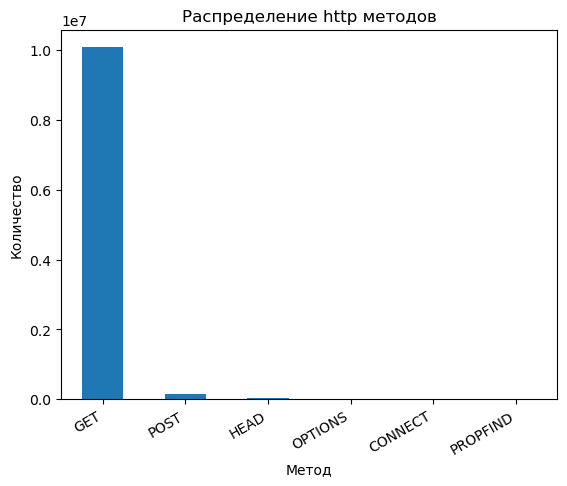

In [72]:
df['method'].value_counts().plot(kind='bar')
plt.title('Распределение http методов')
plt.xlabel('Метод')
plt.xticks(rotation=30, ha='right')  
plt.ylabel('Количество')
plt.show()

По графику видно, что большая часть запросов приходит с методом GET, что объяснимо: пользователи открывают страницы сайта и этим методом подгружаются данные. На втором месте - запросы с методом POST - с их помощью также загружаются данные, кроме этого, с использованием этого метода могут приходить обновления данных: редактированием данных пользователями, оформление заказов.

In [74]:
# Распределение статусов
df['status'].value_counts()

status
200    9563734
304     265032
302     193880
404      97396
301      67402
499      48184
500      14232
403       5490
502        795
401        246
400        128
408        112
504        103
405          6
206          2
Name: count, dtype: int64

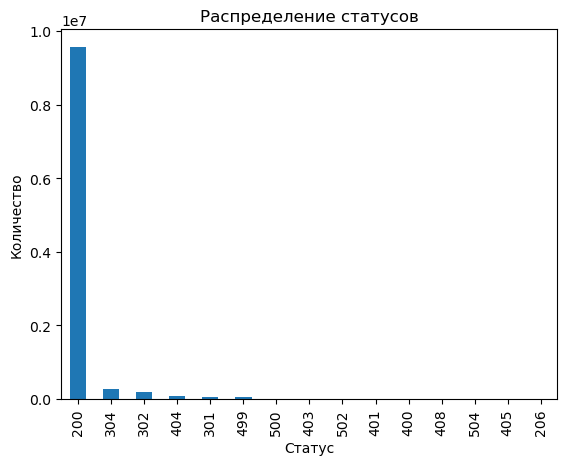

In [76]:
df['status'].value_counts().plot(kind='bar')
plt.title('Распределение статусов')
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.show()

In [70]:
# Добавим новое поле с группой статусов и сгруппируем данные по нему
df_status_cnt = df['status'].value_counts().reset_index()
df_status_cnt['status_group'] = df_status_cnt['status'].astype(str).apply(lambda s: s[:1:] + 'xx')
df_status_cnt.groupby(['status_group'])['count'].sum().reset_index()

,status_group,count
0,2xx,9563736
1,3xx,526314
2,4xx,151562
3,5xx,15130


Согласно графику большая часть запросов проходит успешно (код 200), но также есть часть запросов с ошибками. Чаще других встречаются ошибки перенаправления (3хх), клиентские ошибки (4хх), на третьем месте серверные ошибки (5хх) (что является позитивным моментом, значит, наш функционал, по большей части, работает корректно).

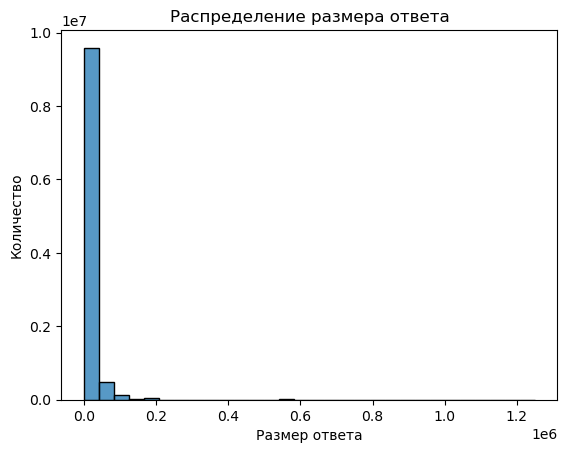

In [78]:
# Распределение размера ответа
sns.histplot(df['size'], bins=30)
plt.title('Распределение размера ответа')
plt.xlabel('Размер ответа')
plt.ylabel('Количество')
plt.show()

In [80]:
df['size'].describe().apply(lambda x: format(x, '.3f'))

count    10256742.000
mean        12537.642
std         28233.034
min             0.000
25%          2088.000
50%          4120.000
75%         11915.000
max       1249490.000
Name: size, dtype: object

Ответы по размеру, как правило небольшие: до 10000 байт. Но есть и отдельные выбросы до 1,2 Мб. Кроме этого, выше уже отмечалось, что много ответов без тела ответа, то есть с size = 0.

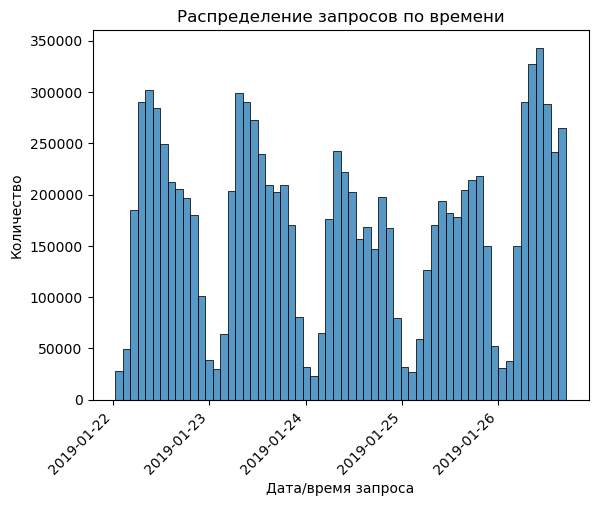

In [87]:
# Распределение запросов по времени
sns.histplot(df['datetime'], bins=60)
plt.title('Распределение запросов по времени')
plt.xlabel('Дата/время запроса')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')          
plt.show()

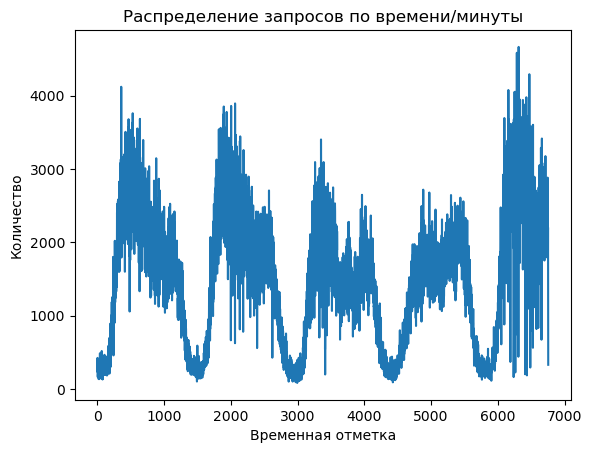

In [336]:
# Запросы в минуту
aggByMin = df.groupby(['day', 'hour', 'minute'], as_index=False).agg('count')\
  .rename({'client': 'count'}, axis=1).drop(['datetime', 'request'], axis=1)

plt.title('Распределение запросов по времени/минуты')
plt.xlabel('Временная отметка')
plt.ylabel('Количество')
plt.plot(aggByMin['count'], label='load by minute');

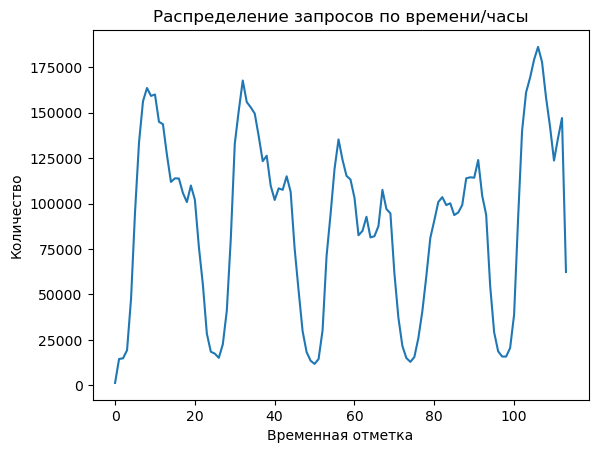

In [338]:
# Запросы в час
aggByHour = df.groupby(['day', 'hour'], as_index=False).agg('count')\
  .rename({'client': 'count'}, axis=1).drop(['datetime', 'request', 'minute'], axis=1)

plt.title('Распределение запросов по времени/часы')
plt.xlabel('Временная отметка')
plt.ylabel('Количество')
plt.plot(aggByHour['count'], label='load by hour');

Нагрузка по запросам в минуту/в час имеет явный тренд зависимости от времени суток: ночью количество запросов падает, днём - увеличивается. Также стоит отметить повышенную нагрузку 26.01 (суббота) - в выходные пользователи более активно посещают маркетплейс.<br>Такая статистика может помочь для определения времени плановых работ на серверах: выбрать часы наименьшей нагрузки.

In [266]:
# Датасет с ошибками в ответах
df_error = df[df["status"] != 200]

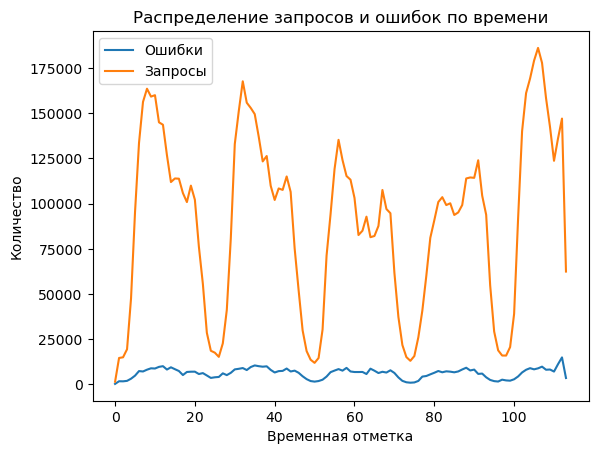

In [313]:
# Ошибки в час
aggErrorByHour = df_error.groupby(['day', 'hour'], as_index=False).agg('count')\
  .rename({'client': 'count'}, axis=1).drop(['datetime', 'request', 'minute'], axis=1)

plt.title('Распределение запросов и ошибок по времени')
plt.xlabel('Временная отметка')
plt.ylabel('Количество')
plt.plot(aggErrorByHour['count'], label='Ошибки');
plt.plot(aggByHour['count'], label='Запросы');
plt.legend()

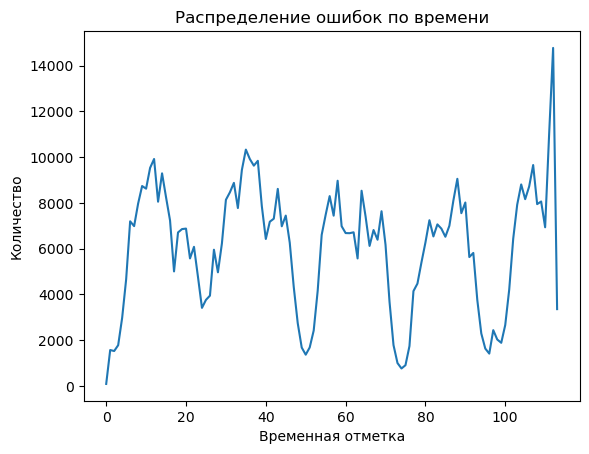

In [315]:
plt.title('Распределение ошибок по времени')
plt.xlabel('Временная отметка')
plt.ylabel('Количество')
plt.plot(aggErrorByHour['count'], label='error by hour');

Распределение ошибок по времени суток повторяет динамику аналогичного распределения запросов (больше в дневное время и выходной). Также можно отметить, что явных сбоев (резкого увеличения количества ошибок при том же количестве запросов) не было.

### Фильтрация данных

In [157]:
# Удаление запросов от ботов
df_filtered = df[df["user_agent"].str.contains( \
    'bot|crawler|spider|cfnetwork|guzzlehttp|okhttp|indeedbot|SEMrushBot|ccbot|-', regex=True) == False]

In [97]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435015 entries, 0 to 10364864
Data columns (total 13 columns):
 #   Column         Dtype                    
---  ------         -----                    
 0   client         object                   
 1   datetime       datetime64[ns, UTC+03:30]
 2   method         category                 
 3   request        object                   
 4   status         int16                    
 5   size           int32                    
 6   referer        object                   
 7   user_agent     category                 
 8   traffic_label  object                   
 9   ref            object                   
 10  day            int64                    
 11  hour           int64                    
 12  minute         int64                    
dtypes: category(2), datetime64[ns, UTC+03:30](1), int16(1), int32(1), int64(3), object(5)
memory usage: 547.4+ MB


После удаления запросов от ботов общее количество строк сократилось существенно (примерно на 40%), из чего можно сделать вывод, что почти половину запросов отправляют не реальные пользователи, а боты.

In [159]:
# Удаление запросов медиафайлов
df_filtered = df_filtered[df_filtered["request"].str.contains( \
    '.css|.png|.jpg|.jpeg|.mp3|.js|.cdn|.gif|image|.doc|.html|logo|.ico|.txt', regex=True) == False]

In [106]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747038 entries, 7 to 10364844
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype                    
---  ------         --------------   -----                    
 0   client         747038 non-null  object                   
 1   datetime       747038 non-null  datetime64[ns, UTC+03:30]
 2   method         747038 non-null  category                 
 3   request        747038 non-null  object                   
 4   status         747038 non-null  int16                    
 5   size           747038 non-null  int32                    
 6   referer        747038 non-null  object                   
 7   user_agent     747038 non-null  category                 
 8   traffic_label  747038 non-null  object                   
 9   ref            747038 non-null  object                   
 10  day            747038 non-null  int64                    
 11  hour           747038 non-null  int64                    
 12  minut

После удаления запросов медиафайлов количество записей токже существенно уменьшилось (примерно на 90%), что объясняется большим количеством различных медиафайлов и скриптов на веб-страницах сайта.

In [119]:
df_filtered['status'].value_counts()

status
200    640155
302     44406
499     25802
301     19590
404     15380
500       935
403       298
401       246
502       143
400        35
408        34
304         8
405         6
Name: count, dtype: int64

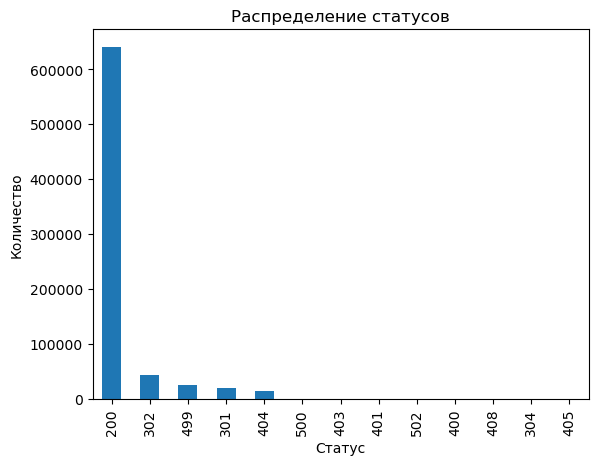

In [121]:
df_filtered['status'].value_counts().plot(kind='bar')
plt.title('Распределение статусов')
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.show()

In [161]:
# Удаление ответов с ошибками
df_filtered = df_filtered[df_filtered["status"] == 200]

In [21]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640155 entries, 7 to 10364844
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype                    
---  ------         --------------   -----                    
 0   client         640155 non-null  object                   
 1   datetime       640155 non-null  datetime64[ns, UTC+03:30]
 2   method         640155 non-null  category                 
 3   request        640155 non-null  object                   
 4   status         640155 non-null  int16                    
 5   size           640155 non-null  int32                    
 6   referer        640155 non-null  object                   
 7   user_agent     640155 non-null  category                 
 8   traffic_label  640155 non-null  object                   
 9   ref            640155 non-null  object                   
 10  day            640155 non-null  int64                    
 11  hour           640155 non-null  int64                    
 12  minut

Также удалим ответы с ошибками, в дальнейшем анализе будем ориентироваться только на успешно выполненные запросы. 

### Группировка данных: топ посетителей

In [163]:
# Топ-10 пользователей по посещаемости (группировка по ip и устройству)
df_filtered_client = df_filtered.groupby(['client', 'user_agent']).size().reset_index(name='count')

/var/folders/3d/whfq5d751m95ywvngtpfg71w0000gn/T/ipykernel_27126/1276697176.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered_client = df_filtered.groupby(['client', 'user_agent']).size().reset_index(name='count')


In [165]:
df_filtered_client = df_filtered_client[df_filtered_client['count'] > 0]
df_filtered_client.sort_values(by='count', ascending=False).head(10)

,client,user_agent,count
1416521949,91.99.72.15,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.7(KHTML, like Gecko) Chrome/16.0.912.36 Safari/535.7",9701
1416522855,91.99.72.15,"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.92 Safari/537.36",9627
1416522456,91.99.72.15,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0,9604
1416521237,91.99.72.15,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_3) AppleWebKit/534.55.3 (KHTML, like Gecko) Version/5.1.3 Safari/534.53.10",9556
50865972,130.185.76.185,Mozilla/5.0 (Windows NT 6.1; rv:65.0) Gecko/20100101 Firefox/65.0,8257
531636208,34.247.132.53,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.84 Safari/537.36",6686
1413517667,91.99.30.32,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0,6462
1414622888,91.99.47.57,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0,5204
50837602,130.185.74.243,Mozilla/5.0 (Windows NT 6.1; rv:42.0) Gecko/20100101 Firefox/42.0,5194
1105104330,5.78.190.233,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0,4869


В таблице представлены ip адреса, с которых приходило больше всего запросов (с учётом устройств пользователей). Представлены следующие страны (это страны, к которым привязана большая часть ip из соответствующей группы):
- Германия (91.0.0.0)
- США (130.0.0.0, 34.0.0.0)
- Великобритания (5.0.0.0)

In [167]:
# Топ-10 пользователей по посещаемости (группировка по ip)
df_filtered.groupby(['client']).size().reset_index(name='count') \
            .sort_values(by='count', ascending=False).head(10)

,client,count
49984,91.99.72.15,38488
3505,151.239.241.163,18942
49878,91.99.30.32,8938
1794,130.185.76.185,8257
49917,91.99.47.57,7147
18759,34.247.132.53,6686
38995,5.78.190.233,6525
1793,130.185.74.243,5194
22968,46.4.203.149,4749
49983,91.99.72.148,4564


Если произвести группировку просто по ip адресам без устройств, то картина не меняется. И в этот раз представлены страны:
- Германия (91.0.0.0, 46.0.0.0)
- США (130.0.0.0, 34.0.0.0)
- Великобритания (5.0.0.0, 151.0.0.0)

In [170]:
# Добавим поле для группы ip адресов
df_filtered_client['ip_group'] = df_filtered_client['client'].str.extract(r'^(\d+\.)') + '0.0.0'

In [172]:
df_filtered_client.groupby('ip_group')['count'].sum().reset_index(name='count') \
            .sort_values(by='count', ascending=False).head(10)

,ip_group,count
137,5.0.0.0,124885
175,91.0.0.0,79566
96,2.0.0.0,39179
52,151.0.0.0,36360
134,46.0.0.0,32634
83,185.0.0.0,24415
126,37.0.0.0,21494
85,188.0.0.0,19139
173,89.0.0.0,18495
122,31.0.0.0,17482


Если произвести группировку по группам ip адресов, то в топе будут страны:
- Великобритания (5.0.0.0, 2.0.0.0, 151.0.0.0, 188.0.0.0)
- Германия (91.0.0.0, 46.0.0.0, 37.0.0.0, 31.0.0.0)
- США (130.0.0.0, 34.0.0.0)
- Швейцария (185.0.0.0)
- Таиланд (89.0.0.0)
<br>
Такое возможно из-за того, что в одной группе адресов ip-адреса могут относиться к разным странам, но большинство относится к странам, указанным в списке выше.

In [174]:
# Добавим поле с ОС
def classify_user_agent(user_agent):
    if 'Windows' in user_agent:
        return 'Windows'
    elif 'iPhone' in user_agent:
        return 'iPhone'
    elif 'Mac' in user_agent:
        return 'Mac'
    elif 'Android' in user_agent:
        return 'Android'
    elif 'Linux' in user_agent:
        return 'Linux'
    else:
        return 'other'

df_filtered_client['os'] = df_filtered_client['user_agent'].apply(classify_user_agent)

In [176]:
df_filtered_client.head()

,client,user_agent,count,ip_group,os
27308,1.158.74.178,"Mozilla/5.0 (iPhone; CPU iPhone OS 12_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/71.0.3578.89 Mobile/15E148 Safari/605.1",3,1.0.0.0,iPhone
53172,1.234.99.77,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko,2,1.0.0.0,Windows
84121,1.36.128.224,"Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1",3,1.0.0.0,iPhone
112460,1.46.105.255,"Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1",1,1.0.0.0,iPhone
140799,1.46.167.44,"Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1",1,1.0.0.0,iPhone


In [332]:
# Сгруппируем запросы по ОС
df_filtered_client_os = df_filtered_client.groupby('os')['count'].sum().reset_index() \
                .sort_values(by='count', ascending=False) 
df_filtered_client_os

,os,count
3,Windows,499730
4,iPhone,54972
0,Android,43955
2,Mac,21427
1,Linux,16599
5,other,3472


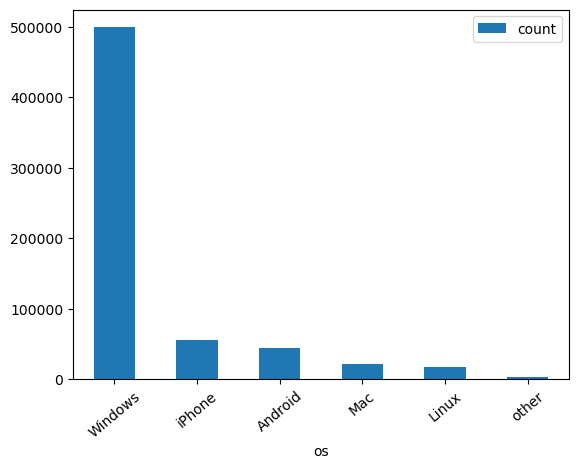

In [346]:
df_filtered_client_os.plot.bar(x = 'os', y = 'count', rot = 40);

В группировке по ОС видим, что чаще всего (причём с очень большим отрывом) на сайт заходили пользователи Windows, затем - пользователи мобильных устройств (iPhone и Android). Эта информация может помочь, например, при выборе того, что развивать в первую очередь: сайт или приложение для мобильных устройств. Как мы видим, преобладающая часть пользователей заходят на сайт с компьютеров/ноутбуков, но также не стоит упускать из вида пользователей мобильных устройств, их удобство пользования сайтом/приложением тоже стоит принимать во внимание.

### Группировка данных: топ сайтов, с которых пришли пользователи

In [194]:
# Топ-5 referer по группам traffic-label
df_filtered.groupby('traffic_label')['ref'].value_counts() \
            .groupby(level=0, group_keys=False).head(5)

traffic_label  ref                             
direct                                             100394
other          www.zanbil.ir                       461428
               www-zanbil-ir.cdn.ampproject.org      9577
               ptcnovin.com                          2751
               emalls.ir                             2647
               www.ptcnovin.com                       490
search         www.google.com                       42167
               www.zanbil.ir                        14884
               api.torob.com                         1414
               www.bing.com                           318
               search.mysearch.com                    249
social         org.telegram.messenger                  16
               www.facebook.com                         4
               l.instagram.com                          3
               instagram.com                            1
               l.facebook.com                           1
Name: count, dtype: int6

По данным таблицы можно отметить, что среди поисковиков больше всего запросов пришло из google и из поиска на самом сайте zanbil.ir. Соцсети как источник трафика показали себя очень слабо: суммарно всего 25 запросов. Основное количество запросов - это переходы между страницами сайта (в том числе поиск по сайту).

### Группировка данных: сессии

Попробуем сгруппировать данные по сессиям пользователей (группировка по client, user_agent). Будем считать, что одна сессия длится не более 10 минут. В результате получим список страниц, которые посетил пользователь в пределах одной сессии.

In [196]:
# Определение таймаута сессии в 10 минут
SESSION_THRESHOLD_SECONDS = 10 * 60

df_sorted = df_filtered.sort_values(by=['client', 'user_agent', 'datetime'])
session_info = []
current_client = None
current_user_agent = None
current_session_start = None
current_session_end = None
current_session_pages = []

for index, row in df_sorted.iterrows():
    # Проверить, изменился ли пользователь
    if (row['client'] != current_client or row['user_agent'] != current_user_agent or
            (current_session_start and (row['datetime'] - current_session_end).seconds > SESSION_THRESHOLD_SECONDS)):
        if current_session_start:
            session_info.append((current_client, current_user_agent, current_session_start, current_session_end, current_session_pages))
        
        # Начать новую сессию 
        current_client = row['client']
        current_user_agent = row['user_agent']
        current_session_start = row['datetime']
        current_session_end = row['datetime']
        current_session_pages = [(row['datetime'], row['request'])]
    else:
        # Или дополнить текущую сессию
        current_session_pages.append((row['datetime'], row['request']))
        current_session_end = row['datetime']

In [246]:
# Создать датафрейм из сессий
session_df = pd.DataFrame(session_info)
session_df.columns = ['client', 'user_agent', 'start_time', 'end_time',  'pages']
session_df['pages'] = session_df['pages'].apply(lambda x: [page[1] for page in x])
session_df.sort_values(by = ['start_time']).head()

client  \
71747    91.99.72.15   
9418   178.253.33.51   
71786    91.99.72.15   
27968  34.247.132.53   
18863   2.179.141.98   

                                                                                                                                      user_agent  \
71747                                                                   Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0   
9418   Mozilla/5.0 (Linux; Android 5.1; HTC Desire 728 dual sim) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.83 Mobile Safari/537.36   
71786                                   Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.92 Safari/537.36   
27968                         Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.84 Safari/537.36   
18863                                      Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36   

                     start_time                  end_time  \
71747 2019-01-22 03:56:17+03:30 2019-01-22 11:30:18+03:30   
9418  2019-01-22 03:56:19+03:30 2019-01-22 03:56:19+03:30   
71786 2019-01-22 03:56:19+03:30 2019-01-22 11:29:16+03:30   
27968 2019-01-22 03:56:22+03:30 2019-01-26 20:28:25+03:30   
18863 2019-01-22 03:56:32+03:30 2019-01-22 03:56:45+03:30   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [248]:
# Рассчитаем длительность сессии
session_df['session_time'] = session_df['end_time'] - session_df['start_time']
session_df.sort_values(by='session_time', ascending=False).head()

client  \
27968   34.247.132.53   
9761    185.11.88.198   
55986   62.210.71.205   
63908    84.241.4.124   
9437   178.253.55.194   

                                                                                                               user_agent  \
27968  Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.84 Safari/537.36   
9761                Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36   
55986                                            Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0   
63908  Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36   
9437                Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36   

                     start_time                  end_time  \
27968 2019-01-22 03:56:22+03:30 2019-01-26 20:28:25+03:30   
9761  2019-01-22 13:42:31+03:30 2019-01-26 13:59:26+03:30   
55986 2019-01-22 13:48:28+03:30 2019-01-26 13:59:14+03:30   
63908 2019-01-22 11:50:49+03:30 2019-01-26 11:59:00+03:30   
9437  2019-01-22 14:52:14+03:30 2019-01-26 14:58:25+03:30   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [252]:
# Выведем самые долгие сессии
session_df.sort_values(by='session_time', ascending=False).head()

client  \
27968   34.247.132.53   
9761    185.11.88.198   
55986   62.210.71.205   
63908    84.241.4.124   
9437   178.253.55.194   

                                                                                                               user_agent  \
27968  Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.84 Safari/537.36   
9761                Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36   
55986                                            Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0   
63908  Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36   
9437                Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36   

                     start_time                  end_time  \
27968 2019-01-22 03:56:22+03:30 2019-01-26 20:28:25+03:30   
9761  2019-01-22 13:42:31+03:30 2019-01-26 13:59:26+03:30   
55986 2019-01-22 13:48:28+03:30 2019-01-26 13:59:14+03:30   
63908 2019-01-22 11:50:49+03:30 2019-01-26 11:59:00+03:30   
9437  2019-01-22 14:52:14+03:30 2019-01-26 14:58:25+03:30   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [351]:
# Посмотрим все сессии одного пользователя
session_df[(session_df['client'] == '185.11.88.198') & \
        (session_df['user_agent'] == 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36')] \
        .sort_values(by='start_time').head(5)

,client,user_agent,start_time,end_time,pages,session_time
9761,185.11.88.198,"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36",2019-01-22 13:42:31+03:30,2019-01-26 13:59:26+03:30,"[/filter/b72,p8095, /site/alexaGooleAnalitic, /, /, /site/enamad, /site/alexaGooleAnalitic, /filter/p65%2Cb1%2Cstexists, /site/enamad, /site/alexaGooleAnalitic, /ajaxFilter/p65,b1,stexists,6313%7C49%20%D8%A7%DB%8C%D9%86%DA%86?o=6313, /ajaxFilter/p65,b1,stexists,6313%7C49%20%D8%A7%DB%8C%D9%86%DA%86,6313%7C50%20%D8%A7%DB%8C%D9%86%DA%86?o=6313, /product/33598/64267/%D8%AA%D9%84%D9%88%DB%8C%D8%B2%DB%8C%D9%88%D9%86-%D8%A7%D9%84-%D8%A7%DB%8C-%D8%AF%DB%8C-%D8%B3%D8%A7%D9%85%D8%B3%D9%88%D9%86%DA%AF-%D9%85%D8%AF%D9%84-50NU7900, /site/alexaGooleAnalitic, /basket/alert/64267, /basket/add/64267?addedValues=, /browse/fan/%D9%BE%D9%86%DA%A9%D9%87, /site/alexaGooleAnalitic, /ajaxFilter/p42,b41, /product/2352/1389/%D9%BE%D9%86%DA%A9%D9%87-%D9%BE%D8%A7%DB%8C%D9%87-%D8%A8%D9%84%D9%86%D8%AF-%D9%BE%D8%A7%D8%B1%D8%B3-%D8%AE%D8%B2%D8%B1-%D9%85%D8%AF%D9%84-ES4010RWKM, /site/alexaGooleAnalitic, /basket/alert/1389, /basket/add/1389?addedValues=, /basket/checkout, /province/getProvinceCities?id=1, /site/alexaGooleAnalitic, /basket/checkout?currentStep=2, /province/getProvinceCities?id=1, /site/alexaGooleAnalitic, /province/getProvinceCities?id=8, /basket/checkout?currentStep=3, /province/getProvinceCities?id=1, /site/alexaGooleAnalitic, /order/create, /site/alexaGooleAnalitic]",4 days 00:16:55
9762,185.11.88.198,"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36",2019-01-26 14:13:31+03:30,2019-01-26 14:23:47+03:30,"[/province/getProvinceCities?id=1, /site/alexaGooleAnalitic, /province/getProvinceCities?id=8, /site/alexaGooleAnalitic, /filter/p42,b41, /site/alexaGooleAnalitic, /site/alexaGooleAnalitic, /order/track, /site/alexaGooleAnalitic, /order/track, /site/alexaGooleAnalitic, /order/track, /site/alexaGooleAnalitic]",0 days 00:10:16


Как видим из данных таблиц, можно изучить, какие страницы посетил пользователь за одну сессию, сколько у него на это ушло времени и сколько сессий всего создал данный пользователь. Можно посмотреть, какие страницы пользователи посещают вместе.

In [39]:
# Создание каталога для сохранения результатов
!mkdir output_dir

In [255]:
# Выгрузка данных в файл csv
session_df.to_csv("./output_dir/user_sessions.csv")

Полученные данные по сессиям пользователей можно выгрузить в формате csv для того, чтобы сохранить (например, для сравнения с данными в будущем), или для того, чтобы продолжить анализ с помощью другого инструмента.

### Общие выводы

В данной работе проведён анализ информации из логов сервера, показано, как на основе информации о запросах можно узнать больше о пользователях соответствующего сайта:
- откуда пришло больше всего посетителей,
- какие устройства пользуются наибольшей популярностью у пользователей,
- в какие часы стоит ждать пик посещений,
- что именно делают пользователи на сайте, какие страницы посещают,
- сколько времени пользователи проводят на сайте,
- как много ошибок ответов и как часто они происходят,
- сколько "реальных пользователей" и сколько ботов отправляют запросы на сайт.

В качестве направлений расширения данного исследования можно указать следующие:
- Было бы интересно провести исследование данных с заполненными user_id пользователей, тогда сессии можно было бы привязать к отдельным пользователям. Если была бы доступна информация о заказах пользователей с данными user_id, можно было бы отследить пути пользователей/переходы по страницам сайта, которые наиболее вероятно приведут к покупке.
- Также можно было бы более детально изучить, какие именно страницы входят в одну сессию, есть ли какие-то закономерности в переходах между страницами. Возможно, это могло бы улучшить систему рекомендаций: предлагать те товары, которые чаще всего попадают в одну сессию с текущим товаром.
- Кроме этого, можно было бы более детально изучить географию пользователей: ориентироваться не на группы ip адресов, a на конкретные ip-адреса. Добавить интеграцию с сервисом, предоставляющим информацию о локации по данным об ip. Локации можно нанести на карту и посмотреть географию пользователей в наглядном виде. Также можно сопоставить, в какой локации какие страницы пользуются наибольшей популярностью и, например, таргетировать рекламу по этим данным.